This script tries to replicate the MNIST results in the paper.

In [1]:
from __future__ import print_function

import tensorflow as tf
from math import sqrt

from tensorflow.examples.tutorials.mnist import input_data

import optimizers
import util

BATCH_SIZE = 128
LR = 1e-5
N_STEPS = 50000
REPORT_STEPS = 1000
RAND_SEED = 100

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class Mnist_model():
  def __init__(self, seed=None):
    with tf.name_scope('mnist_model'):
      self.images = tf.placeholder(tf.float32, [None, 784])
      self.labels = tf.placeholder(tf.float32, [None, 10])

      with tf.name_scope('fc1'):
        W_fc1 = tf.Variable(tf.truncated_normal([784, 100], stddev=1.0/sqrt(784), seed=seed))
        b_fc1 = tf.Variable(tf.truncated_normal([100], stddev=0.1, seed=seed))
        h_fc1 = tf.nn.relu(tf.matmul(self.images, W_fc1) + b_fc1)
      with tf.name_scope('fc2'):
        W_fc2 = tf.Variable(tf.truncated_normal([100, 10], stddev=1.0/sqrt(100), seed=seed))
        b_fc2 = tf.Variable(tf.truncated_normal([10], stddev=0.1, seed=seed))
        logits = tf.matmul(h_fc1, W_fc2) + b_fc2

      self.logits = logits
      self.preds = tf.nn.softmax(logits)
      KL_div = tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,
                                                       logits=logits)
      self.loss = tf.reduce_mean(KL_div)
      correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(self.labels, 1))
      correct_prediction = tf.cast(correct_prediction, tf.float32)
      self.acc = tf.reduce_mean(correct_prediction)
    

In [3]:
n_models = 2
models = [Mnist_model(RAND_SEED) for _ in range(n_models)]
names = ['ADAM', 'AMS']
train_steps = [tf.train.AdamOptimizer(LR).minimize(models[0].loss),
               optimizers.AMSGrad(LR).minimize(models[1].loss)]

train_loss_lists = [[] for m in range(n_models)]
test_acc_lists = [[] for m in range(n_models)]
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for step in range(N_STEPS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    for m in range(n_models):
      sess.run(train_steps[m], feed_dict={models[m].images: batch[0], 
                                          models[m].labels: batch[1]})
      if step % REPORT_STEPS == 0:
        tr_loss = sess.run(models[m].loss, feed_dict={models[m].images: batch[0], 
                                                      models[m].labels: batch[1]})
        te_acc = sess.run(models[m].acc, feed_dict={models[m].images: mnist.test.images, 
                                                    models[m].labels: mnist.test.labels})
        print('step %d, %s, train loss %.3g; test acc %.4g' % (step, names[m], tr_loss, te_acc))
        train_loss_lists[m].append(tr_loss)
        test_acc_lists[m].append(te_acc)


step 0, ADAM, train loss 2.36; test acc 0.1121
step 0, AMS, train loss 2.36; test acc 0.1121
step 1000, ADAM, train loss 1.58; test acc 0.7034
step 1000, AMS, train loss 1.58; test acc 0.7033
step 2000, ADAM, train loss 1.15; test acc 0.8255
step 2000, AMS, train loss 1.16; test acc 0.8248
step 3000, ADAM, train loss 0.759; test acc 0.8562
step 3000, AMS, train loss 0.772; test acc 0.8558
step 4000, ADAM, train loss 0.635; test acc 0.8705
step 4000, AMS, train loss 0.656; test acc 0.8699
step 5000, ADAM, train loss 0.661; test acc 0.8809
step 5000, AMS, train loss 0.689; test acc 0.8789
step 6000, ADAM, train loss 0.387; test acc 0.8895
step 6000, AMS, train loss 0.426; test acc 0.8864
step 7000, ADAM, train loss 0.402; test acc 0.8955
step 7000, AMS, train loss 0.443; test acc 0.8918
step 8000, ADAM, train loss 0.324; test acc 0.899
step 8000, AMS, train loss 0.367; test acc 0.8953
step 9000, ADAM, train loss 0.374; test acc 0.9036
step 9000, AMS, train loss 0.419; test acc 0.8992
ste

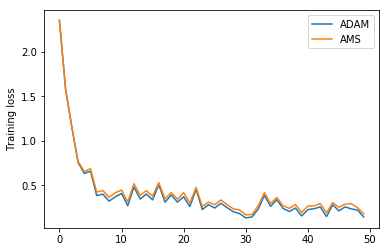

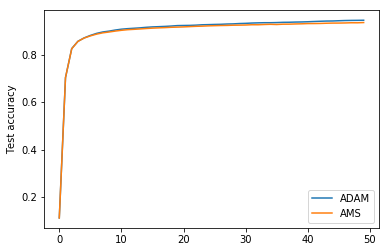

In [4]:
util.plot_results(train_loss_lists, names, 'Training loss')
util.plot_results(test_acc_lists, names, 'Test accuracy')